#  Predict Happiness Source

- Importing the Packages

In [54]:
# importing packages
import pandas as pd 
import numpy as np                     # For mathematical calculations 
import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings warnings.filterwarnings("ignore")

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import PorterStemmer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import nltk
import re
import codecs
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [55]:
import pandas as pd
import numpy as np
#import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

- Reading the data

In [56]:
train=pd.read_csv('hm_train.csv')
test=pd.read_csv('hm_test.csv')
submission=pd.read_csv('sample_submission.csv')

In [57]:
print(train.columns,test.columns,submission.columns)
print(train.head(),test.head(),submission.head())
print(train.shape,test.shape,submission.shape)

Index(['hmid', 'reflection_period', 'cleaned_hm', 'num_sentence',
       'predicted_category'],
      dtype='object') Index(['hmid', 'reflection_period', 'cleaned_hm', 'num_sentence'], dtype='object') Index(['hmid', 'predicted_category'], dtype='object')
    hmid reflection_period                                         cleaned_hm  \
0  27673               24h  I went on a successful date with someone I fel...   
1  27674               24h  I was happy when my son got 90% marks in his e...   
2  27675               24h       I went to the gym this morning and did yoga.   
3  27676               24h  We had a serious talk with some friends of our...   
4  27677               24h  I went with grandchildren to butterfly display...   

   num_sentence predicted_category  
0             1          affection  
1             1          affection  
2             1           exercise  
3             2            bonding  
4             1          affection       hmid reflection_period          

- Let’s make a copy of train and test data so that even if we have to make any changes in these datasets we would not lose the original datasets.



In [58]:
train_copy=pd.read_csv('hm_train.csv').copy()
test_copy=pd.read_csv('hm_test.csv').copy()
submission_copy=pd.read_csv('sample_submission.csv').copy()

# Univariate Analysis

In [59]:
print(train.dtypes,test.dtypes,submission.dtypes)

hmid                   int64
reflection_period     object
cleaned_hm            object
num_sentence           int64
predicted_category    object
dtype: object hmid                  int64
reflection_period    object
cleaned_hm           object
num_sentence          int64
dtype: object hmid                   int64
predicted_category    object
dtype: object


In [60]:
train['predicted_category'].value_counts(normalize=True)
# Read as percentage after multiplying by 100

affection           0.346148
achievement         0.336102
bonding             0.108768
enjoy_the_moment    0.107889
leisure             0.070324
nature              0.018683
exercise            0.012085
Name: predicted_category, dtype: float64

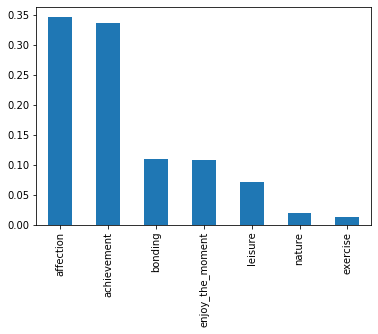

In [61]:
train['predicted_category'].value_counts(normalize=True).plot.bar()

- exercise featurescontributes approx 2%, nature contributes 3.5 %, leisure contributes 7.5%, enjoy_the_moment does 10%, bonding does 10%, achievement does 34%, and affection does34.5 % to the population sample.

On Looking at the datsets, we identified that there are 3 Data Types:

- Continuous : reflection_period, cleaned_hm ,num_sentence

- Categorical :Category

- Text : cleaned_hm

Let's go for Continuous Data Type Exploration. We know that we use BarGraphs for Categorical variable, Histogram or ScatterPlot for continuous variables.

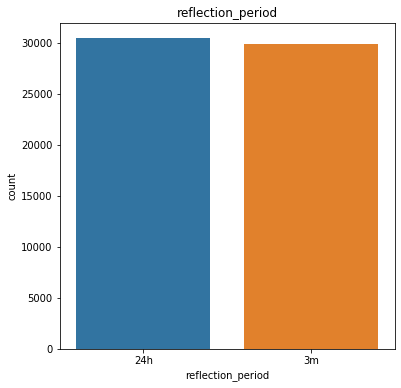

In [62]:
# reflection_period
plt.figure(figsize=(6, 6))
sns.countplot(train["reflection_period"])
plt.title('reflection_period')
plt.show()

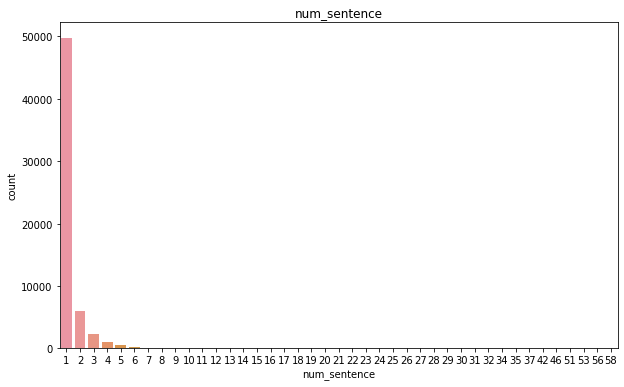

In [63]:
# num_sentence
plt.figure(figsize=(10, 6))
sns.countplot(train["num_sentence"])
plt.title('num_sentence')
plt.show()

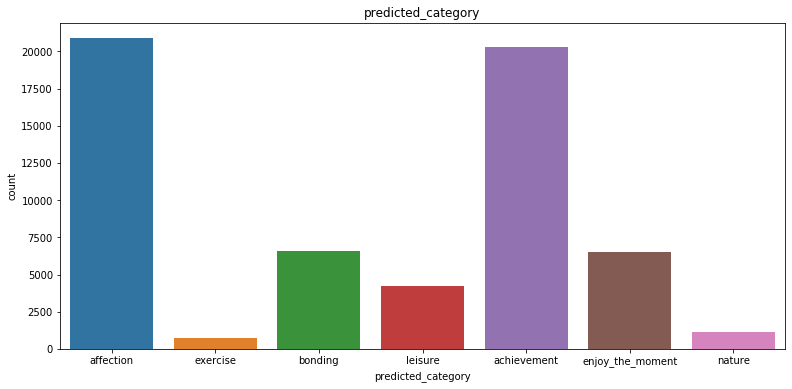

In [64]:
# predicted_category
plt.figure(figsize=(13, 6))
sns.countplot(train["predicted_category"])
plt.title('predicted_category')
plt.show()


<Figure size 2160x2160 with 0 Axes>

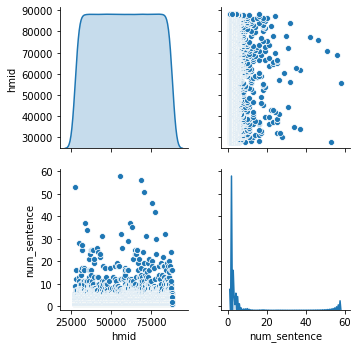

In [65]:
# Pairplot for cross visualisation of continuous variables
plt.figure(figsize=(30,30))
sns.pairplot(train, diag_kind='kde');

Data Preprocessing

- Checking Missing Values

In [66]:
def missing_value(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_df = pd.concat([total, percent], axis=1, keys = ['Total', 'Percent'])
    return missing_df

In [67]:
mis_train = missing_value(train)
mis_train

,Total,Percent
predicted_category,0,0.0
num_sentence,0,0.0
cleaned_hm,0,0.0
reflection_period,0,0.0
hmid,0,0.0


In [68]:
mis_test = missing_value(test)
mis_test

,Total,Percent
num_sentence,0,0.0
cleaned_hm,0,0.0
reflection_period,0,0.0
hmid,0,0.0


Text Preprocessing

- Let's try to understand the writing style if possible :)

In [69]:
grouped_df = train.groupby('predicted_category')
for name, group in grouped_df:
    print("Text : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["cleaned_hm"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Text :  achievement
I made a new recipe for peasant bread, and it came out spectacular!
I was shorting Gold and made $200 from the trade.
Managed to get the final trophy in a game I was playing. 
Got A in class.
The cake I made today came out amazing. It tasted amazing as well.


Text :  affection
I went on a successful date with someone I felt sympathy and connection with.
I was happy when my son got 90% marks in his examination 
I went with grandchildren to butterfly display at Crohn Conservatory

I got gift from my elder brother which was really surprising me
Watching cupcake wars with my three teen children


Text :  bonding
We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.
went to movies with my friends it was fun 
I helped my neighbour to fix their car damages. 
A hot kiss with my girl friend last night made my day
We were competing against another team in a online game, I was playing with my friends

Though, there are not very special Characters but some are present like expression of emoji's i.e. :), vs, etc

### Feature Engineering:

Now let us come try to do some feature engineering. This consists of two main parts.

- Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
- Text based features - features directly based on the text / words like frequency, svd, word2vec etc.


#### Meta Features:

We will start with creating meta featues and see how good are they at predicting the happiness source. The feature list is as follows:

   - Number of words in the text
   - Number of unique words in the text
   - Number of characters in the text
   - Number of stopwords
   - Number of punctuations
   - Number of upper case words
   - Number of title case words
   - Average length of the words


Feature Engineering function

In [70]:
import string

In [71]:
def feature_engineering(df):
    
    ## Number of words in the text ##
    df["num_words"] = df['cleaned_hm'].apply(lambda x: len(str(x).split()))
    
    ## Number of unique words in the text ##
    df["num_unique_words"] = df['cleaned_hm'].apply(lambda x: len(set(str(x).split())))
    
    ## Number of characters in the text ##
    df["num_chars"] = df['cleaned_hm'].apply(lambda x: len(str(x)))
    
    ## Number of stopwords in the text ##
    from nltk.corpus import stopwords
    eng_stopwords = stopwords.words('english')
    df["num_stopwords"] = df['cleaned_hm'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
    
    ## Number of punctuations in the text ##
    df["num_punctuations"] =df['cleaned_hm'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    ## Number of title case words in the text ##
    df["num_words_upper"] = df['cleaned_hm'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    
    ## Number of title case words in the text ##
    df["num_words_title"] = df['cleaned_hm'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    
    ## Average length of the words in the text ##
    df["mean_word_len"] = df['cleaned_hm'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    df = pd.concat([df, df["num_words"],df["num_unique_words"],df["num_chars"],df["num_stopwords"],df["num_punctuations"],
                    df["num_words_upper"],df["num_words_title"],df["mean_word_len"]],axis=1)
    
    #X = dataset.loc[:,['Transaction-Type','Complaint-reason','Company-response','Consumer-disputes','delayed','converted_text','convertion_language']]
    
    return df

In [72]:
train = feature_engineering(train)
test = feature_engineering(test)

In [73]:
train.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,...,num_words_title,mean_word_len,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,27673,24h,I went on a successful date with someone I fel...,1,affection,14,13,77,6,1,...,2,4.571429,14,13,77,6,1,2,2,4.571429
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection,12,12,57,6,1,...,1,3.750000,12,12,57,6,1,1,1,3.750000
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise,10,10,44,6,1,...,1,3.500000,10,10,44,6,1,1,1,3.500000
3,27676,24h,We had a serious talk with some friends of our...,2,bonding,25,23,130,15,2,...,2,4.240000,25,23,130,15,2,0,2,4.240000
4,27677,24h,I went with grandchildren to butterfly display...,1,affection,10,10,71,4,0,...,3,5.900000,10,10,71,4,0,1,3,5.900000


Let us now plot some of our new variables to see of they will be helpful in predictions.

CLEANING THE TEXT !!!

In [74]:
def preprocess_text(df):
    
    """ Here, The function preprocesses the text. It performs stemming, lemmatization
    , stopwords removal, common words and rare words removal and removal of unwanted chractaers. """
    
    #removing non-letter symbols and converting text in 'cleaned_hm' to lowercase 
    df = df.apply(lambda x: "".join(re.sub(r"[^A-Za-z\s]", '',str(x))))
    
    # lower casing the Text
    df = df.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    #Removing punctuations
    #adding characters list which needs to remove that is PUNCTUATION
    punc = ['.', ',', '"', "'", '?','#', '!', ':','vs',':)', ';', '(', ')', '[', ']', '{', '}',"%",'/','<','>','br','�','^','XX','XXXX','xxxx','xx']
    #removing extra characters
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in punc))
    
    import nltk
    nltk.download('stopwords')
    
    #removal of stopwords
    from nltk.corpus import stopwords
    stop = stopwords.words('english')
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    
    #common words removal
    freq_df = pd.Series(' '.join(df).split()).value_counts()[:10]
    freq_df = list(freq_df.index)
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in freq_df))
    
    #rare words removal
    freq_df_rare = pd.Series(' '.join(df).split()).value_counts()[-10:]
    freq_df_rare = list(freq_df_rare.index)
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in freq_df_rare))
    
    #STEMMING
    st = PorterStemmer()
    df=df.apply(lambda x: " ".join([st.stem(w) for w in x.split()]))
    
    # WordNet lexical database for lemmatization
    #from nltk.stem import WordNetLemmatizer
    #lem = WordNetLemmatizer()
    #df=df.apply(lambda x: " ".join([lem.lemmatize(w) for w in x.split()]))
    
    return df    

In [75]:
train['cleaned_hm'] = preprocess_text(train['cleaned_hm'])
test['cleaned_hm'] = preprocess_text(test['cleaned_hm'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
# Removing 'h or m extension
train['reflection_period'] = train['reflection_period'].str.rstrip('h | m')
test['reflection_period'] = test['reflection_period'].str.rstrip('h | m')

In [78]:
train['reflection_period'].fillna(train['reflection_period'].mode()[0], inplace=True)
train['cleaned_hm'].fillna(train['cleaned_hm'].mode()[0], inplace=True)
train['num_sentence'].fillna(train['num_sentence'].mode()[0], inplace=True)
train['predicted_category'].fillna(train['predicted_category'].mode()[0], inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [79]:
test['reflection_period'].fillna(test['reflection_period'].mode()[0], inplace=True)
test['cleaned_hm'].fillna(test['cleaned_hm'].mode()[0], inplace=True)
test['num_sentence'].fillna(test['num_sentence'].mode()[0], inplace=True)

In [80]:
#NOw We will convert the target variable into LabelEncoder
y_train = train.loc[:,['predicted_category']]
labelencoder1 = LabelEncoder()
labelencoder1.fit(y_train.values)
y_train=labelencoder1.transform(y_train)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
train.columns

Index(['hmid', 'reflection_period', 'cleaned_hm', 'num_sentence',
       'predicted_category', 'num_words', 'num_unique_words', 'num_chars',
       'num_stopwords', 'num_punctuations', 'num_words_upper',
       'num_words_title', 'mean_word_len', 'num_words', 'num_unique_words',
       'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper',
       'num_words_title', 'mean_word_len'],
      dtype='object')

In [82]:
x = train.loc[:,["num_sentence","reflection_period",'num_sentence',
                 'num_words', 'num_unique_words', 'num_chars',
                 'num_stopwords', 'num_punctuations', 'num_words_upper',
                 'num_words_title', 'mean_word_len', 'num_words', 'num_unique_words',
                 'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper',
                 'num_words_title', 'mean_word_len']]

x1 = test.loc[:,["num_sentence","reflection_period",'num_sentence',
                 'num_words', 'num_unique_words', 'num_chars',
                 'num_stopwords', 'num_punctuations', 'num_words_upper',
                 'num_words_title', 'mean_word_len', 'num_words', 'num_unique_words',
                 'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper',
                 'num_words_title', 'mean_word_len']]

In [83]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [84]:
import gensim

In [85]:
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz",limit=50000, binary=True)
wv.init_sims(replace=True)

D:\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [86]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

In [87]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [88]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [89]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [90]:
alldata = pd.concat([train, test], axis=1)

In [91]:
# initialise the functions - we'll create separate models for each type.
countvec = CountVectorizer(analyzer='word', ngram_range = (1,2),  max_features=500)
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,2),  max_features=500)

In [92]:
# create features
bagofwords = countvec.fit_transform(alldata['cleaned_hm'])
tfidfdata = tfidfvec.fit_transform(alldata['cleaned_hm'])

In [93]:
# create dataframe for features
bow_df = pd.DataFrame(bagofwords.todense())
tfidf_df = pd.DataFrame(tfidfdata.todense())

In [94]:
# set column names
bow_df.columns = ['col'+ str(x) for x in bow_df.columns]
tfidf_df.columns = ['col' + str(x) for x in tfidf_df.columns]

In [95]:
# create separate data frame for bag of words and tf-idf

bow_df_train = bow_df[:len(train)]
bow_df_test = bow_df[len(train):]

tfid_df_train = tfidf_df[:len(train)]
tfid_df_test = tfidf_df[len(train):]

In [96]:
# split the merged data file into train and test respectively
train_feats = alldata[~pd.isnull(alldata.predicted_category)]
test_feats = alldata[pd.isnull(alldata.predicted_category)]

In [97]:
# merge count (bag of word) features into train
x_train = pd.concat([x, bow_df_train], axis = 1)
x_test = pd.concat([x1, bow_df_test], axis=1)


x_test.reset_index(drop=True, inplace=True)

In [98]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=-1, penalty = 'l1',C=1.0,random_state = 0)
logreg = logreg.fit(x_train, train['cleaned_hm'])
y_pred = logreg.predict(x_test)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
ans = labelencoder1.inverse_transform(y_pred)
type(ans)
ans = pd.DataFrame(ans)

In [ ]:
id1=test.loc[:,['hmid']]
final_ans = [id1, ans]
final_ans = pd.concat(final_ans, axis=1)
final_ans.columns = ['hmid', 'predicted_category']
final_ans.to_csv('vdemo_HK.csv',index=False)